In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Attention, Dropout, BatchNormalization
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import kerastuner as kt
import random

# Set random seed for reproducibility
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)

# Load Dataset
dataset_path = '/home/hoangbaoan1901/Documents/information-system_UET/sem5/prdan/tianen101/datasets/jrfm-2156907-cleaned.csv'
df = pd.read_csv(dataset_path)

# Define the target variable
target = 'BTC_Close'

# Convert date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Define new training and testing periods
start_day_p2 = pd.Timestamp(2018, 10, 1)
test_day_p2 = pd.Timestamp(2021, 10, 1)
end_day_p2 = pd.Timestamp(2022, 4, 1)

# Filter data for the specified period
period2 = df[(df['Date'] <= end_day_p2)].reset_index(drop=True)
train_dataset_p2 = period2[period2['Date'] < test_day_p2].reset_index(drop=True)
test_dataset_p2 = period2[period2['Date'] >= test_day_p2].reset_index(drop=True)
train_dataset_p2 = train_dataset_p2.drop(columns=['Date'])
test_dataset_p2 = test_dataset_p2.drop(columns=['Date'])

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(df[target].values.reshape(-1, 1))

# Prepare data for GRU
sequence_length = 60
def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(x), np.array(y)

x, y = create_sequences(data_normalized, sequence_length)

# Split into training and testing data based on date
test_index = len(train_dataset_p2) - sequence_length
x_train = x[:test_index]
y_train = y[:test_index]
x_test = x[test_index:]
y_test = y[test_index:]


2024-11-27 09:56:52.304258: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-27 09:56:52.306693: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-27 09:56:52.314083: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-27 09:56:52.326384: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-27 09:56:52.329738: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-27 09:56:52.340048: I tensorflow/core/platform/cpu_feature_gu

In [2]:
# Hyperparameter Optimization using Keras Tuner
def build_model(hp):
    inputs = Input(shape=(sequence_length, 1))
    # Hyperparameter tuning for the number of units and dropout rates
    gru_output = GRU(hp.Int('units', min_value=32, max_value=256, step=32), return_sequences=False)(inputs)
    gru_output = BatchNormalization()(gru_output)
    gru_output = Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1))(gru_output)
    
    dense_output = Dense(hp.Int('dense_units', min_value=32, max_value=128, step=32), activation='relu')(gru_output)
    dense_output = Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1))(dense_output)
    dense_output = Dense(1)(dense_output)

    # Compile GRU model
    model = Model(inputs, dense_output)
    model.compile(optimizer='adam', loss='mse')
    return model

# Hyperparameter tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=1,
    directory='gru_xgb_tuner',
    project_name='gru_xgb'
)

# Early Stopping Callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Search for best hyperparameters
tuner.search(x_train, y_train, epochs=20, validation_split=0.1, callbacks=[early_stopping])

# Get the best hyperparameters
gru_best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print('Best GRU Hyperparameters:')
print(gru_best_hyperparameters.values)

# Get the best model
gru_model = tuner.get_best_models(num_models=1)[0]

# Train the best GRU model
gru_model.fit(x_train, y_train, epochs=50, batch_size=16, validation_split=0.1, callbacks=[early_stopping])

# Extract features from GRU model
feature_extractor = Model(inputs=gru_model.input, outputs=gru_model.layers[-3].output)
train_features = feature_extractor.predict(x_train)
test_features = feature_extractor.predict(x_test)

# Set up hyperparameter optimization for XGBoost
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.005, 0.01, 0.05, 0.1],
    'subsample': [0.6, 0.7, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 1.0]
}

xgb_model = xgb.XGBRegressor()
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid, n_iter=20, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Train XGBoost with optimized hyperparameters
random_search.fit(train_features, y_train)

# Print best hyperparameters for XGBoost
print('Best XGBoost Hyperparameters:')
print(random_search.best_params_)
xgb_best = random_search.best_estimator_

Reloading Tuner from gru_xgb_tuner/gru_xgb/tuner0.json
Best GRU Hyperparameters:
{'units': 160, 'dropout': 0.2, 'dense_units': 32, 'dropout_2': 0.4}
Epoch 1/50


/home/hoangbaoan1901/Development/anaconda3/envs/tf-env/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0026 - val_loss: 0.0521
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0029 - val_loss: 0.0467
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0027 - val_loss: 0.0419
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0026 - val_loss: 0.0150
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0026 - val_loss: 0.0264
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0036 - val_loss: 0.0053
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0029 - val_loss: 9.9163e-04
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0023 - val_loss: 0.0100
Epoch 10/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0021 - val_loss: 0.0057
Epoch 11/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0024 - val_loss: 0.0013
Epoch 12/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms

RMSE: 2626.7614408638574


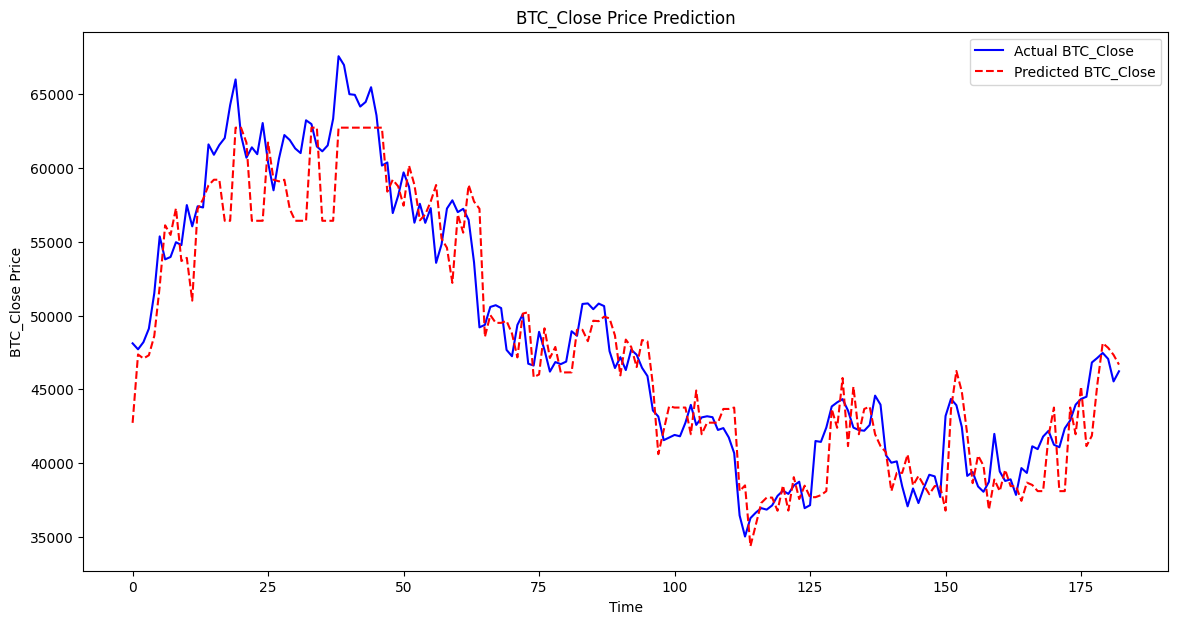

In [3]:
# Make predictions
y_pred = xgb_best.predict(test_features)

# Rescale predictions
y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluation
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print(f'RMSE: {rmse}')

# Plot the predictions against the actual values
plt.figure(figsize=(14, 7))
plt.plot(y_test_rescaled, color='blue', label='Actual BTC_Close')
plt.plot(y_pred_rescaled, color='red', label='Predicted BTC_Close', linestyle='dashed')
plt.title('BTC_Close Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC_Close Price')
plt.legend()
plt.show()